In [10]:
# the cnn module provides classes for training/predicting with various types of CNNs
import opensoundscape

#other utilities and packages
import os
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import random
import subprocess
from glob import glob
import sklearn

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'


In [32]:
#Create metadata CSV for OpenSoundScape module


data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

filepath_presence_dict = {"filepath":[], "presence":[]}

weto_train_dir = os.path.join(data_dir, 'weto', 'train')
for set_key in ['positive', 'negative']:
    set_dir = os.path.join(weto_train_dir, set_key)
    filenames = os.listdir(set_dir)
    filepath_list = filepath_presence_dict["filepath"]
    presence_list = filepath_presence_dict["presence"]
    for name in filenames:
        filepath = os.path.join(set_dir, name)
        filepath_list.append(filepath)
    filepath_presence_dict.update({'filepath': filepath_list})
    if set_key == "positive":
        presence_list = list(np.repeat('positive', len(filenames)))
        filepath_presence_dict.update({'presence': presence_list})
    if set_key == "negative":
        presence_list.extend(list(np.repeat('negative', len(filenames))))
        filepath_presence_dict.update({'presence': presence_list})    


In [54]:
os.listdir("../data")

['weto', 'wofr']

In [71]:
#Create metadata CSV for OpenSoundScape module


data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_dir = "./data"

filepath_presence_dict = {"filepath":[], "presence":[]}

weto_train_dir = data_dir + '/weto/train/'
for set_key in ['positive', 'negative']:
    set_dir = weto_train_dir + set_key
    filenames = os.listdir(set_dir)
    filepath_list = filepath_presence_dict["filepath"]
    presence_list = filepath_presence_dict["presence"]
    for name in filenames:
        filepath = set_dir + '/' +name
        filepath_list.append(filepath)
    filepath_presence_dict.update({'filepath': filepath_list})
    if set_key == "positive":
        presence_list = list(np.repeat('positive', len(filenames)))
        filepath_presence_dict.update({'presence': presence_list})
    if set_key == "negative":
        presence_list.extend(list(np.repeat('negative', len(filenames))))
        filepath_presence_dict.update({'presence': presence_list})    


In [72]:
set_dir

'./data/weto/train/negative'

In [73]:
meta_weto = pd.get_dummies(pd.DataFrame(filepath_presence_dict), columns = ['presence'], prefix = "", prefix_sep="", dtype = int).set_index('filepath')
#meta_weto = pd.DataFrame(filepath_presence_dict).set_index('filepath')

meta_weto.index.names = ['file']

display(meta_weto.head(3), meta_weto.tail(3))
print(f"There are {np.sum(meta_weto['positive'])} positive samples")
print(f"There are {np.sum(meta_weto['negative'])} negative samples")

,negative,positive
file,,
./data/weto/train/positive/A-11-E_20210430_230000_99_5_0-3.wav,0,1
./data/weto/train/positive/A-11-E_20210503_230000_26_9_0-3.wav,0,1
./data/weto/train/positive/A-11-E_20210503_230000_26_9_3-6.wav,0,1


,negative,positive
file,,
./data/weto/train/negative/A-9_20210515_230000_120_8_3-6.wav,1,0
./data/weto/train/negative/A-9_20210515_230000_60_4_0-3.wav,1,0
./data/weto/train/negative/A-9_20210515_230000_63_5_0-3.wav,1,0


There are 590 positive samples
There are 755 negative samples


In [74]:
meta_weto_balanced = opensoundscape.data_selection.resample(meta_weto, 
                                       n_samples_per_class = 800, 
                                       upsample=True, 
                                       downsample=True, 
                                       with_replace=False, 
                                       random_state=42)

print(f"There are {np.sum(meta_weto_balanced['positive'])} positive samples")
print(f"There are {np.sum(meta_weto_balanced['negative'])} negative samples")

There are 800 positive samples
There are 800 negative samples


In [75]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import SpectrogramPreprocessor
from opensoundscape.ml.datasets import AudioFileDataset, AudioSplittingDataset

pre = SpectrogramPreprocessor(sample_duration=2.0)
dataset = AudioFileDataset(meta_weto_balanced,pre)

In [76]:
dataset[0]

PreprocessingError: failed to preprocess sample from path: data\weto\train\negative\A-11-E_20210426_230000_0_4_0-3.wav

In [77]:
train_df, valid_df = sklearn.model_selection.train_test_split(meta_weto_balanced, test_size=0.1, random_state=0)
train_df


,negative,positive
file,,
./data/weto/train/positive/A-120-W_20210506_230000_120_19_6-9.wav,0,1
./data/weto/train/positive/A-11-E_20210511_230000_0_19_15-18.wav,0,1
./data/weto/train/negative/A-11-S_20210503_230000_60_19_0-3.wav,1,0
./data/weto/train/negative/A-111_20210505_230000_120_8_3-6.wav,1,0
./data/weto/train/negative/A-74_20210511_230000_120_4_0-3.wav,1,0
...,...,...
./data/weto/train/negative/A-47_20210503_230000_0_4_0-3.wav,1,0
./data/weto/train/positive/A-11-E_20210506_230000_60_19_9-12.wav,0,1
./data/weto/train/positive/A-120-W_20220525_230000_0_4_0-3.wav,0,1


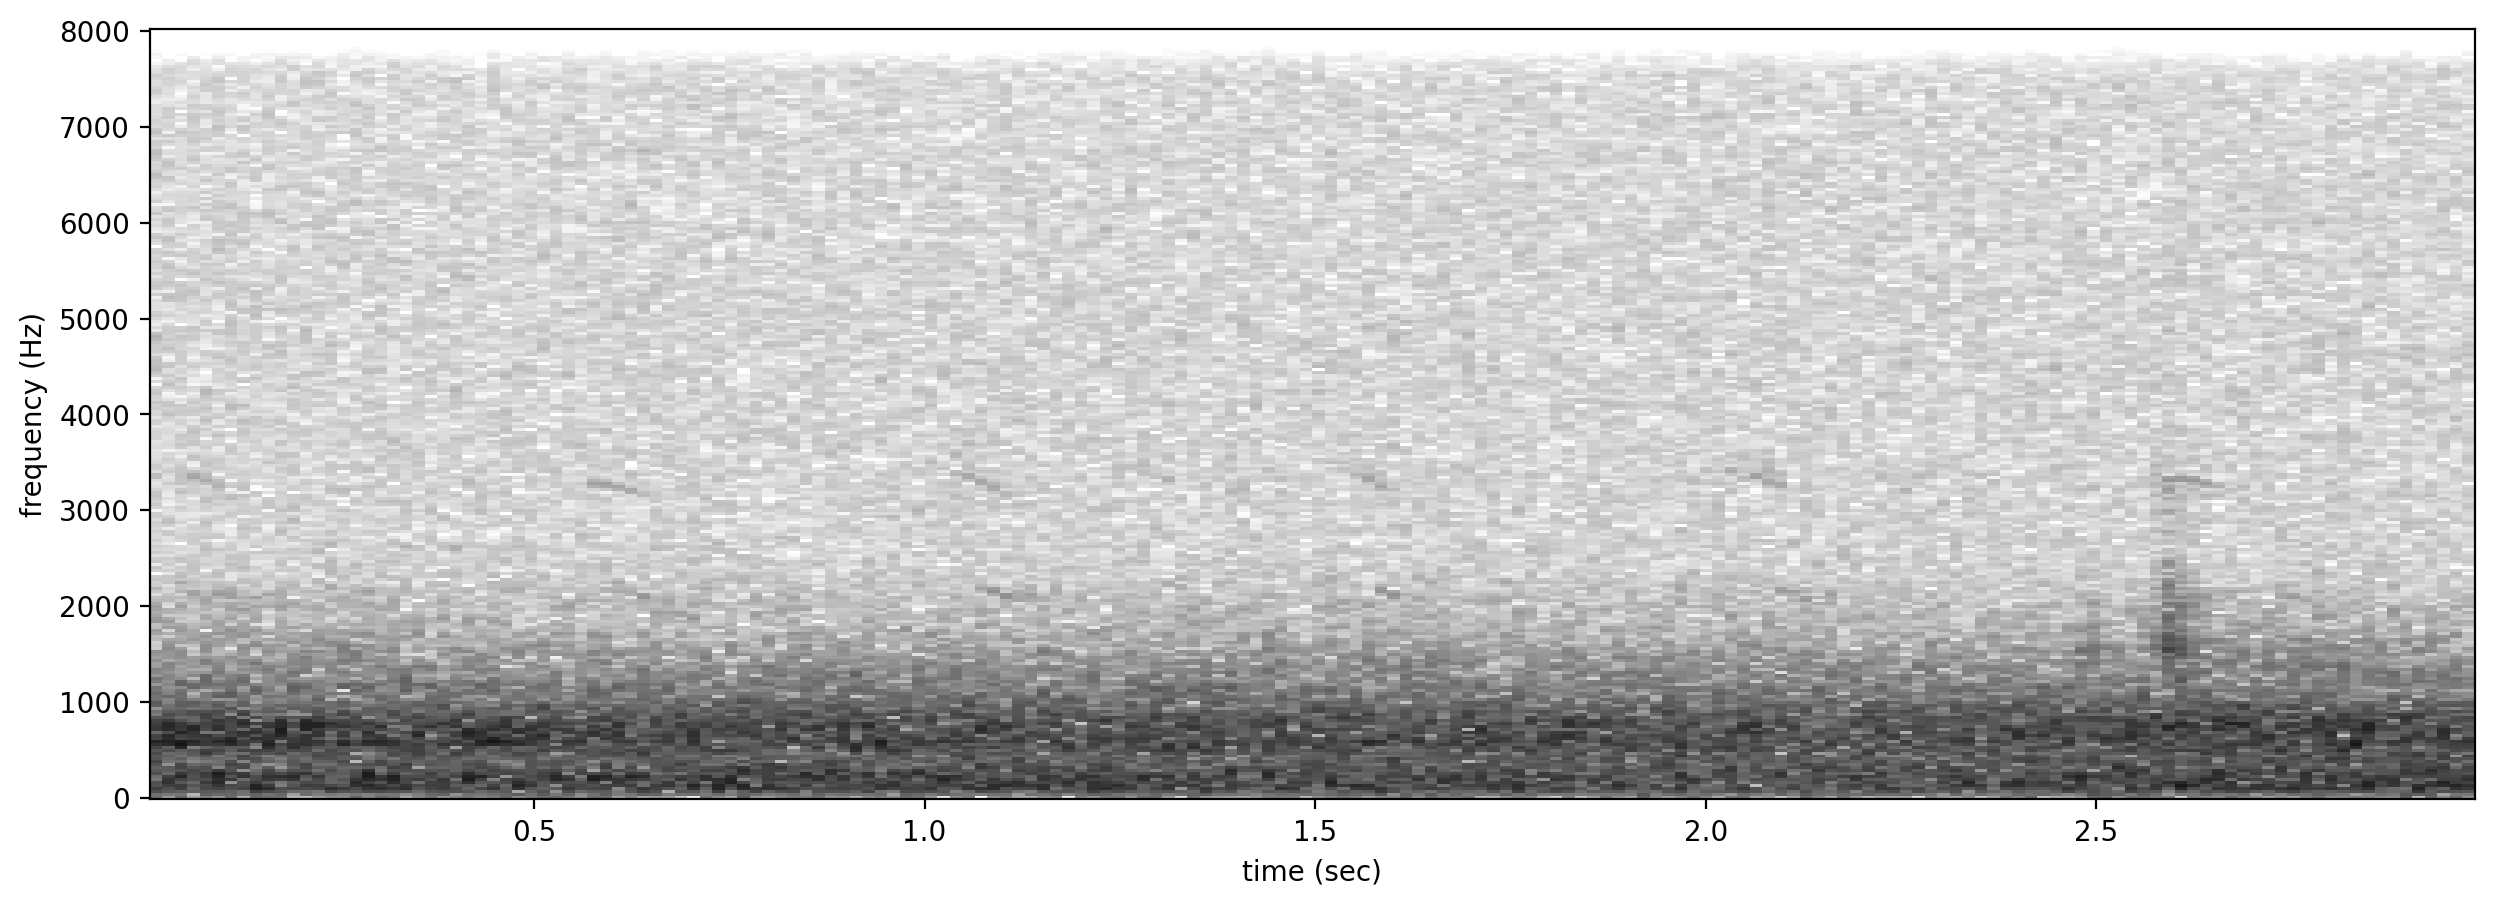

<Audio(samples=(48000,), sample_rate=16000)>

In [78]:
from opensoundscape import Audio, Spectrogram

path = train_df.index[10]
audio_object = Audio.from_file(path)
spectrogram_object = Spectrogram.from_audio(audio_object)
spectrogram_object.plot()
audio_object

In [79]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration = 3) #3s, selected above

print(f'model.device is: {model.device}')

model.device is: cuda:0


In [ ]:
#Set up WandB
#Must downgrade Ipython to avoid error messages 
    #pip install ipython==8.16.1

import wandb
try:
    wandb.login()
    wandb_session = wandb.init(
        entity='pca_bioacoustics', #replace with your entity/group name
        project='bioacoustics_model',
        name='Train CNN',
    )
except: #if wandb.init fails, don't use wandb logging
    print('failed to create wandb session. wandb session will be None')
    wandb_session = None

In [80]:
checkpoint_folder = Path("model_training_checkpoints")
checkpoint_folder.mkdir(exist_ok=True)
checkpoint_folder_path = os.path.join(os.getcwd(), "model_training_checkpoints")

In [81]:
#%%capture --no-stdout --no-display
# Uncomment the line above to silence outputs from this cell

model.train(
    train_df,
    valid_df,
    epochs = 30,
    batch_size = 32,
    log_interval = 100, #log progress every 100 batches
    #num_workers = 4, #4 parallelized cpu tasks for preprocessing
    #wandb_session = wandb_session,
    save_interval = 10, #save checkpoint every 10 epochs
    save_path = checkpoint_folder_path #location to save checkpoints
)

c:\Users\gavin hurd\.conda\envs\amphib_pt_remote\lib\site-packages\opensoundscape\utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
c:\Users\gavin hurd\.conda\envs\amphib_pt_remote\lib\site-packages\opensoundscape\utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
c:\Users\gavin hurd\.conda\envs\amphib_pt_remote\lib\site-packages\opensoundscape\utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 


Training Epoch 0


c:\Users\gavin hurd\.conda\envs\amphib_pt_remote\lib\site-packages\opensoundscape\utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
c:\Users\gavin hurd\.conda\envs\amphib_pt_remote\lib\site-packages\opensoundscape\utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
c:\Users\gavin hurd\.conda\envs\amphib_pt_remote\lib\site-packages\opensoundscape\utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

  0%|          | 0/45 [00:00<?, ?it/s]

IndexError: None of the samples in the SafeDataset loaded. All samples caused exceptions during preprocessing. The mostrecent exception is in the error trace. 